# Assignment 5 - Watch through the eyes of an autonomous car
Since last year, [competitions](https://www.meetup.com/fr-FR/DIY-Robocars-France/?_cookie-check=LfyK7Ga4keoQnT--) are regularly organized in Paris for mini autonomous cars races.

You can make a team, [build](https://diyrobocars.com/2017/10/01/a-minimum-viable-racer-for-openmv/) your own mini autonomous car with a neural network inside a Raspberry Pi, and try to compete with other teams. The fastest car to finish 3 tracks wins.

This assignment is deeply inspired by this [article](https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476). Here, we want to "see" what our neural network has learnt: 
- we first train the car using a very simple dataset: the guys were driving the car with a wifi remote, they saved a lot of screenshots from the camera of the car in order to get a realistic dataset, and they labeled each image by the steering angle of the remote. 1000 = full left, 1500 = straight ahead, 2000 = full right.
- after the training, the car is able to drive by itself, because it recognizes when to turn and when to go straight forward.
- but what exactly did it learn to recognize ? Is it the dot lines in the middle of the road ? the road by itself ? the white lines on the borders ot the road ?

Here is the site to go if you want to try to build your own mini car and compete with it: http://ironcar.org/

In [2]:
from IPython.display import HTML
HTML('<iframe width="1855" height="983" src="https://www.youtube.com/embed/TvsbozvtdBw" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Install dependencies and dataset

In [3]:
# Install a library that we will use for neural network explanation
# See here for more: https://github.com/slundberg/shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 21.3 MB/s 


In [4]:
# Download the dataset
#!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/self-driving-toy-car.zip 
!wget https://s3.amazonaws.com/axionautdataset/Datasets+2.zip

--2022-11-22 17:08:21--  https://s3.amazonaws.com/axionautdataset/Datasets+2.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.136.64, 54.231.168.104, 52.217.232.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.136.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1719750362 (1.6G) [application/zip]
Saving to: ‘Datasets+2.zip’

Datasets+2.zip      100%[===================>]   1.60G  13.1MB/s    in 2m 10s  

2022-11-22 17:10:32 (12.6 MB/s) - ‘Datasets+2.zip’ saved [1719750362/1719750362]



In [5]:
#!unzip self-driving-toy-car.zip 
!unzip Datasets+2.zip

Archive:  Datasets+2.zip
   creating: Datasets/
  inflating: Datasets/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/Datasets/
  inflating: __MACOSX/Datasets/._.DS_Store  
   creating: Datasets/ironcar_data/
  inflating: Datasets/ironcar_data/.DS_Store  
   creating: __MACOSX/Datasets/ironcar_data/
  inflating: __MACOSX/Datasets/ironcar_data/._.DS_Store  
   creating: Datasets/ironcar_data/old_track/
  inflating: Datasets/ironcar_data/old_track/balanced_iron_Y.npy  
   creating: __MACOSX/Datasets/ironcar_data/old_track/
  inflating: __MACOSX/Datasets/ironcar_data/old_track/._balanced_iron_Y.npy  
  inflating: Datasets/ironcar_data/old_track/balanced_iron_X.npy  
  inflating: __MACOSX/Datasets/ironcar_data/old_track/._balanced_iron_X.npy  
  inflating: __MACOSX/Datasets/ironcar_data/._old_track  
   creating: Datasets/ironcar_data/new_track/
  inflating: Datasets/ironcar_data/new_track/y_chicane.npy  
   creating: __MACOSX/Datasets/ironcar_data/new_track/
  inflating: __MA

# Initialize constants
This is hands-on is heavily inspired of this [notebook](https://github.com/Axionable/Axionaut).

Here, the behaviour of the car is very simple, and can be greatly improved.
The neural network learns the steering between 5 possibilities: hard right, right, straight, left and hard left.

No acceleration, no slowing down, only one car on the track. Even if that model is that simple, it was the winner of the second [IronCar France](http://ironcar.org/) robocar competition (in 2018).

In [6]:
def label_decoder(line):
    '''Returns human-readible label from target array.
    
    '''
    if np.array_equal(line, [1,0,0,0,0]):
        return 'hard_right'
    elif np.array_equal(line, [0,1,0,0,0]):
        return 'soft_right'
    elif np.array_equal(line, [0,0,1,0,0]):
        return 'straight'
    elif np.array_equal(line, [0,0,0,1,0]):
        return 'soft_left'
    elif np.array_equal(line, [0,0,0,0,1]):
        return 'hard_left'
    else:
        print('Error: Label not recognized.')
        return 

    
def label_decoder_int(line):
    '''Convert label from array to integer.
    
    '''
    if np.array_equal(line, [1,0,0,0,0]):
        return -1
    elif np.array_equal(line, [0,1,0,0,0]):
        return -0.5
    elif np.array_equal(line, [0,0,1,0,0]):
        return 0
    elif np.array_equal(line, [0,0,0,1,0]):
        return 0.5
    elif np.array_equal(line, [0,0,0,0,1]):
        return 1
    else:
        print('Error: Label not recognized.')
        return

In [7]:
import numpy as np

# Load dada from Numpy array
X_axio = np.load('Datasets/axionable_data/X_train_axio.npy')
Y_axio = np.load('Datasets/axionable_data/Y_train_axio.npy')
print('Axionable data Loaded. Shape = ', np.shape(X_axio))

Axionable data Loaded. Shape =  (26449, 90, 250, 3)


In [8]:

# New track - Double chicane
X_chicane = np.load('Datasets/ironcar_data/new_track/x_chicane.npy')
Y_chicane = np.load('Datasets/ironcar_data/new_track/y_chicane.npy')
# Old track - Balan8ced dataset
X_iron = np.load('Datasets/ironcar_data/old_track/balanced_iron_X.npy')
Y_iron = np.load('Datasets/ironcar_data/old_track/balanced_iron_Y.npy')
# New double Chicane
X_chicane2 = np.load('Datasets/new/x_chicane.npy')
Y_chicane2 = np.load('Datasets/new/y_chicane.npy')

In [9]:

# Concatenate both augmented datasets in a single one
X = np.concatenate((X_axio, X_chicane, X_iron, X_chicane2))
Y = np.concatenate((Y_axio, Y_chicane, Y_iron, Y_chicane2))
print('Total X shape after augmentation = ', np.shape(X))

Total X shape after augmentation =  (47165, 90, 250, 3)


         0    1    2    3    4  direction
0      0.0  0.0  0.0  1.0  0.0        0.5
1      0.0  0.0  0.0  1.0  0.0        0.5
2      0.0  0.0  0.0  1.0  0.0        0.5
3      0.0  0.0  0.0  1.0  0.0        0.5
4      0.0  0.0  0.0  1.0  0.0        0.5
...    ...  ...  ...  ...  ...        ...
47160  0.0  0.0  0.0  0.0  1.0        1.0
47161  0.0  0.0  0.0  0.0  1.0        1.0
47162  0.0  0.0  0.0  0.0  1.0        1.0
47163  0.0  0.0  0.0  0.0  1.0        1.0
47164  0.0  0.0  0.0  0.0  1.0        1.0

[47165 rows x 6 columns]


(array([ 5623.,     0., 10141.,     0.,     0., 16623.,     0.,  9671.,
            0.,  5107.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

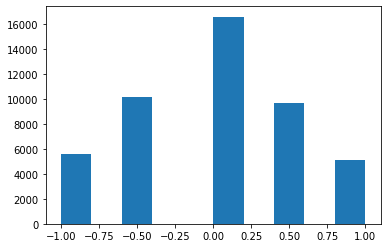

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert targets to a Pandas Data Frame
df = pd.DataFrame(Y)

# Convert targets to integer (-1 = hard_right, 1 = hard_left)
df['direction'] = df.apply(label_decoder_int, axis=1)
print(df)

# Check that the dataset is representative of reality, in order to avoid biases: 
# most of the cases should be "going straight forward", some should be "right" or "left", fewer should be "full right" or "full left"`
plt.hist(df['direction']) 

# Read the data

## Read an image and the corresponding steering angle
The data were collected by driving the car manually, with a wifi remote, and saving the commands of the driver.

X contains the images watched by the car, Y contains the corresponding commands issued by the driver.

In [11]:
import cv2
import numpy as np

def read_image_and_steering(img_number):
  
  image = X[img_number]
  steer = Y[img_number]
  
  return image, steer 

In [12]:

def draw_steer(image, steer, color):
    center = (image.shape[1]//2, image.shape[0]//2)
    offset = (image.shape[1]//2 + int(-label_decoder_int(steer)*image.shape[1]/2), image.shape[0]//2)
    
    img = image.copy()
    cv2.arrowedLine(img, center, offset, color=color, thickness=1, tipLength=0.4)
    
    return img

[0. 0. 0. 1. 0.]


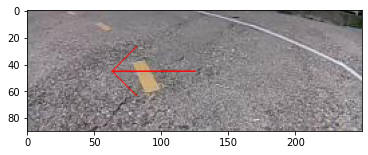

In [13]:
import random
import matplotlib.pyplot as plt

random_img_number = random.randint(0, X.shape[0]-1)
img_test, steer_test = read_image_and_steering(random_img_number)

print(steer_test)
img_test_with_steer = draw_steer(img_test, steer_test, (255, 0, 0))
plt.imshow(img_test_with_steer)

##Augment the dataset
As usual, we add random transformations to the images, so that the neural network would learn to drive in different conditions: dark, light, shadows...

In [14]:

def horizontal_flip(img, steer):
    """Horizontal image flipping and angle correction.
    Img: Input image to transform in Numpy array.
    Angle: Corresponding label. Must be a 5-elements Numpy Array.
    """    
    return np.fliplr(img), np.flipud(steer)


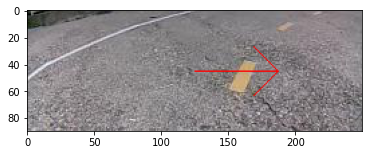

In [15]:
img_test_flip, steer_test_flip = horizontal_flip(img_test, steer_test)
img_test_flip_with_steer = draw_steer(img_test_flip, steer_test_flip, (255, 0, 0))
plt.imshow(img_test_flip_with_steer)

In [16]:
def augment_brightness_camera_images(image):
    '''Random bright augmentation (both darker and brighter).
    
    Returns:
    Transformed image and label.
    '''
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

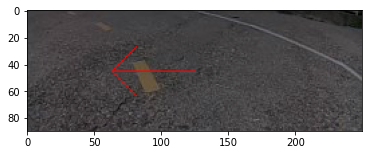

In [17]:
img_test_bright = augment_brightness_camera_images(img_test)
img_test_bright_with_steer = draw_steer(img_test_bright, steer_test, (255, 0, 0))
plt.imshow(img_test_bright_with_steer)

In [18]:

def add_random_shadow(image):
    '''Add random dark shadows to a given image.
    Returns:
    Transformed image and label.
    '''
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


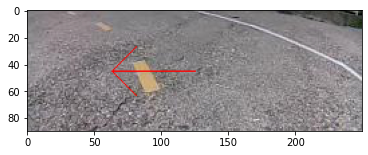

In [19]:
img_test_shadow = add_random_shadow(img_test)
img_test_shadow_with_steer = draw_steer(img_test_shadow, steer_test, (255, 0, 0))
plt.imshow(img_test_shadow_with_steer)

In [20]:

import skimage.exposure as exposure

def night_effect(img, vmin=185, vmax=195):
    """Change road color to black simulating night road.
    Returns
    Transformed image and label.
    """
    limit = random.uniform(vmin,vmax)
    low_limit = 146 
    int_img = exposure.rescale_intensity(img, in_range=(low_limit,limit), out_range='dtype')
    
    return int_img

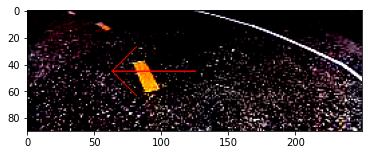

In [21]:

img_test_night = night_effect(img_test)
img_test_night_with_steer = draw_steer(img_test_night, steer_test, (255, 0, 0))
plt.imshow(img_test_night_with_steer)

In [22]:

def adjust_gamma_dark(image, min_=0.7, max_=0.8):
    '''Gamma correction to generate darker images.
    Image: Image in Numpy format (90,250,3)
    Label: Corresponding label of the image.
    Min: Minimum gamma value (the lower the darker)
    Max: Maximum gamma value (the higher the brigther) 
    Return:
    Transformed image and label.
    '''
    # build a lookup table mapping the pixel values [0, 255] to
    gamma = random.uniform(min_,max_)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


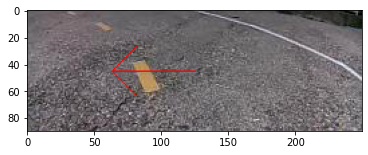

In [23]:

img_test_dark = adjust_gamma_dark(img_test)
img_test_dark_with_steer = draw_steer(img_test_dark, steer_test, (255, 0, 0))
plt.imshow(img_test_dark_with_steer)

In [24]:
def augment(image, steer):
  
    randomValue = random.uniform(0, 1)
    if randomValue < 0.25:
      image = adjust_gamma_dark(image)
    elif randomValue < 0.5:
      image = night_effect(image)
    elif randomValue < 0.75:
      image = add_random_shadow(image)
    elif randomValue <= 1: 
      image = augment_brightness_camera_images(image)

    randomValueFlip = random.randint(0,1)
    if randomValueFlip == 1:
      image, steer = horizontal_flip(image, steer)
    
    return image, steer

[0. 1. 0. 0. 0.]


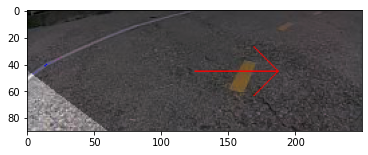

In [25]:
img_test_augmented, steer_augmented = augment(img_test, steer_test)
print(steer_augmented)
img_test_augmented_with_steer = draw_steer(img_test_augmented, steer_augmented, (255, 0, 0))
plt.imshow(img_test_augmented_with_steer)

##Create a generator for Keras

In [26]:
from itertools import chain
from itertools import islice

def batch_generator(imgs, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    # https://stackoverflow.com/questions/24527006/split-a-generator-into-chunks-without-pre-walking-it
    iterator = iter(imgs)
    for first in iterator:        
        yield list(chain([first], islice(iterator, batch_size - 1)))

In [27]:

def normalize(image):
    '''Return image centered around 0 with +- 0.5.
    image: Image to transform in Numpy array.
    '''
    return image/255.-.5

In [28]:

def train_generator(imgs_numbers, batch_size, shuffle = True, jitter = True, norm=True):
  
    if shuffle: np.random.shuffle(imgs_numbers)
      
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(imgs_numbers, batch_size):
          
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for img_num in batch:
              
                image, steer = read_image_and_steering(img_num) # YOUR CODE HERE: read the image number img_num and its steering
                
                if jitter: augment(image, steer)# YOUR CODE HERE: augment the image
                if norm: normalize(image) # YOUR CODE HERE: normalize the image
                  
                batch_imgs.append(image)
                batch_targets.append(steer)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = np.stack(batch_targets, axis=0)
            yield batch_imgs, batch_targets

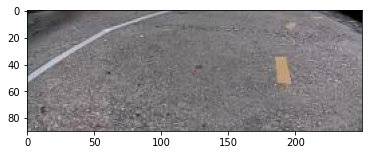

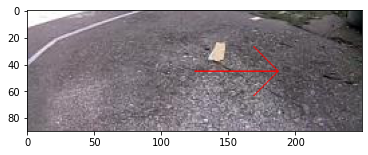

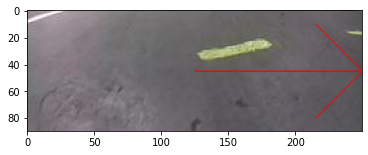

In [29]:

# test training generator
NB_IMGS_TEST = 3

img_numbers = np.random.choice(len(X), size=NB_IMGS_TEST)
for imgs, steers in train_generator(img_numbers, NB_IMGS_TEST, norm=False):
    for img, steer in zip(imgs, steers):
      img = draw_steer(img, steer, (255, 0, 0))
      plt.imshow(img)
      plt.show()
    break

# Construct the neural network
The proposed architecture is a slightly modified version of the PilotNet published by [Nvidia](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf). This architecture is powerful to modelize all possible driving situations while simple enough to run on the raspberry pi 3 B+. Dropout of 10% was added on two classifier layers to avoid overfitting.

In [30]:
IMG_SIZE = X.shape[1:]
IMG_SIZE

(90, 250, 3)

In [31]:
from skimage.color.colorconv import xyz2luv
import tensorflow as tf
# Lately, Shap has become incompatible with Keras 2.4+, so you have to use
# a trick, see https://stackoverflow.com/questions/66814523/shap-deepexplainer-with-tensorflow-2-4-error
tf.compat.v1.disable_v2_behavior()

def model_categorical(input_size= IMG_SIZE, dropout=0.1):
    '''Generate an NVIDIA AutoPilot architecture.
    Input_size: Image shape (90, 250, 3), adjust to your desired input.
    Dropout: Proportion of dropout used to avoid model overfitting.
    This model ONLY predicts steering angle as a 5-elements array encoded with a Softmax output.
    The model is already compiled and ready to be trained.
    '''

    img_in = tf.keras. Input(shape=input_size, name='img_in')
    x = tf.keras.layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), activation='relu') (img_in) 
    x = tf.keras. layers.Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='relu')(x) 
    x = tf. keras. layers. Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), activation='relu')(x) 
    x = tf.keras. layers. Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(x) 
    x = tf.keras. layers. Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(x)

    x = tf.keras. layers.Flatten(name= 'flattened')(x)
    x = tf.keras. layers. Dense (100, activation='relu')(x)
    x = tf.keras. layers.Dropout (dropout)(x)
    x = tf.keras. layers. Dense (50, activation='relu')(x)
    x = tf.keras. layers.Dropout (dropout)(x)
    
    #categorical output of the angle
    angle_out = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[img_in], outputs=[angle_out])
    
    return model
  
model = model_categorical()
    

Instructions for updating:
non-resource variables are not supported in the long term


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_in (InputLayer)         [(None, 90, 250, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 43, 123, 24)       1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 60, 32)        19232     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 28, 64)         51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 26, 64)         36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 24, 64)         36928     
                                                                 
 flattened (Flatten)         (None, 6144)              0     

In [33]:

from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=5, mode='auto', verbose=1)
checkpoint  = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

In [34]:

from sklearn.model_selection import train_test_split

# batch generator
BATCH_SIZE = 32
# BATCH_SIZE = 16

imgs_num_train, imgs_num_test = train_test_split(list(range(len(X))), test_size=0.15)

num_train = len(imgs_num_train)//BATCH_SIZE
num_valid = len(imgs_num_test)//BATCH_SIZE


In [35]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit_generator(generator = train_generator (imgs_num_train, BATCH_SIZE),
                    steps_per_epoch = num_train,
                    epochs = 6,
                    verbose = 1,
                    validation_data = train_generator (imgs_num_test, BATCH_SIZE, jitter = False),
                    validation_steps = num_valid,
                    callbacks = [early_stop, checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/6
1252/1252 [==============================] - ETA: 0s - batch: 625.5000 - size: 32.0000 - loss: 0.5624 - acc: 0.7845

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.14112, saving model to weights.hdf5
1252/1252 [==============================] - 58s 39ms/step - batch: 625.5000 - size: 32.0000 - loss: 0.5624 - acc: 0.7845 - val_loss: 0.1411 - val_acc: 0.9519
Epoch 2/6
1251/1252 [============================>.] - ETA: 0s - batch: 625.0000 - size: 31.9952 - loss: 0.1326 - acc: 0.9572
Epoch 2: val_loss improved from 0.14112 to 0.06128, saving model to weights.hdf5
1252/1252 [==============================] - 48s 38ms/step - batch: 625.5000 - size: 31.9952 - loss: 0.1325 - acc: 0.9573 - val_loss: 0.0613 - val_acc: 0.9800
Epoch 3/6
1252/1252 [==============================] - ETA: 0s - batch: 625.5000 - size: 31.9952 - loss: 0.0763 - acc: 0.9760
Epoch 3: val_loss did not improve from 0.06128
1252/1252 [==============================] - 46s 36ms/step - batch: 625.5000 - size: 31.9952 - loss: 0.0763 - acc: 0.9760 - val_loss: 0.0857 - val_acc: 0.9747
Epoch 4/6
1252/1252 [==============================] - ETA: 0s - 

# Check the predictions of the steering angle

[0. 1. 0. 0. 0.]
None


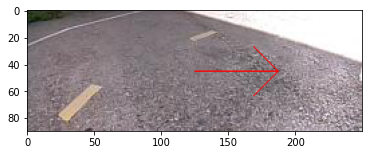

In [ ]:

img_test, steer_test = read_image_and_steering(random.choice(imgs_num_test))

print(steer_test)
img_test = draw_steer(img_test, steer_test, (255, 0, 0))
plt.imshow(img_test)


# YOUR CODE HERE: predict the steering for img_test. Don't forget to normalize the image
# before feeding it into the network (because the learning was made on normalized images)
steer_pred = None
print(steer_pred)
    

# Explain the predictions
See https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models

In [36]:
import shap

In [37]:
background = []

for _ in range(100):
  img, steer = X[random.choice(imgs_num_test)],Y[random.choice(imgs_num_test)] #YOUR CODE HERE: using random.choice(), chose an image number from imgs_num_test, and read that image and its steering 
  background.append(normalize(img)) # The model was trained on normalized images, so we have to normalize them before feeding them into the DeepExplainer
background = np.array(background).astype(np.float32)

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [38]:
# ...or pass tensors directly
shap_values = e.shap_values(background[1:5]) #YOUR CODE HERE By refering to the url above, compute the shap values of some of the images that you stored in background
# Warning: you have to denormalize the images (ie. revert the normalize operation)

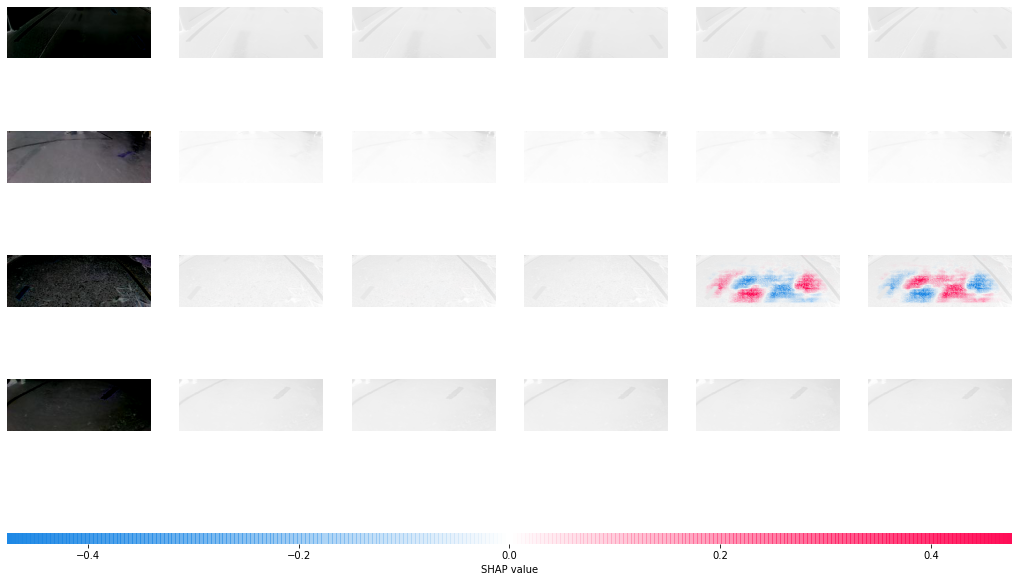

In [39]:
# plot the feature attributions
shap.image_plot(shap_values, -background[1:5]) #YOUR CODE HERE By refering to the url above, plot the chosen images and their shap values
# Warning: again, you have to denormalize the images (ie. revert the normalize operation)

##Optional: use [tf-explain](https://www.sicara.ai/blog/2019-07-31-tf-explain-interpretability-tensorflow) instead of SHAP

The SHAP library has become incompatible with Tensorflow 2.4+, so we had to use a little trick above. You can try with another explainability library, that might work better.